In [1]:
from bluemath_tk.core.io import load_model

dwt = load_model("outputs/dwt_model_aveiro.pkl")
dwt

In [2]:
from datetime import datetime

annual_probs_df = dwt.clusters_annual_probs_df.copy()
annual_probs_df.index = [datetime(year, 1, 1) for year in annual_probs_df.index]
annual_probs_df.index.name = "time"
annual_probs_df.columns = [f"Cluster-{i + 1}" for i in range(annual_probs_df.shape[1])]
annual_probs = annual_probs_df.to_xarray()
annual_probs

<xarray.Dataset> Size: 16kB
Dimensions:     (time: 54)
Coordinates:
  * time        (time) datetime64[ns] 432B 1970-01-01 1971-01-01 ... 2023-01-01
Data variables: (12/36)
    Cluster-1   (time) float64 432B 0.03288 0.008219 0.0 ... 0.01644 0.02454
    Cluster-2   (time) float64 432B 0.005479 0.01096 ... 0.008219 0.006135
    Cluster-3   (time) float64 432B 0.04384 0.02466 ... 0.008219 0.01534
    Cluster-4   (time) float64 432B 0.00274 0.02192 0.02732 ... 0.0137 0.003067
    Cluster-5   (time) float64 432B 0.008219 0.005479 ... 0.01096 0.006135
    Cluster-6   (time) float64 432B 0.01644 0.03014 0.05464 ... 0.02192 0.04601
    ...          ...
    Cluster-31  (time) float64 432B 0.03014 0.0274 0.03279 ... 0.008219 0.09816
    Cluster-32  (time) float64 432B 0.01918 0.03288 0.01093 ... 0.03562 0.03988
    Cluster-33  (time) float64 432B 0.04384 0.04932 0.02732 ... 0.03288 0.003067
    Cluster-34  (time) float64 432B 0.02192 0.0 0.01366 ... 0.01918 0.04601
    Cluster-35  (time) float64 432B 0.0411 0.1041 0.05738 ... 0.08767 0.04908
    Cluster-36  (time) float64 432B 0.06301 0.0137 0.04645 ... 0.02192 0.0

In [3]:
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.datamining.kma import KMA
from bluemath_tk.predictor.xwt import XWT

pca = PCA(n_components=3)
pca.set_logger_name(name="PCA_", console=False)
kma = KMA(num_clusters=3)

awt = XWT(steps={"pca": pca, "kma": kma})
awt.fit(
    data=annual_probs,
    fit_params={
        "pca": {
            "vars_to_stack": list(annual_probs.data_vars),
            "coords_to_stack": ["time"],
            "pca_dim_for_rows": "time",
        },
        "kma": {
            "normalize_data": False,
            "min_number_of_points": 10,
            "max_number_of_iterations": 1000,
        },
    },
)
awt.save_model("outputs/awt_model_aveiro.pkl")


        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 3
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


<Axes: >

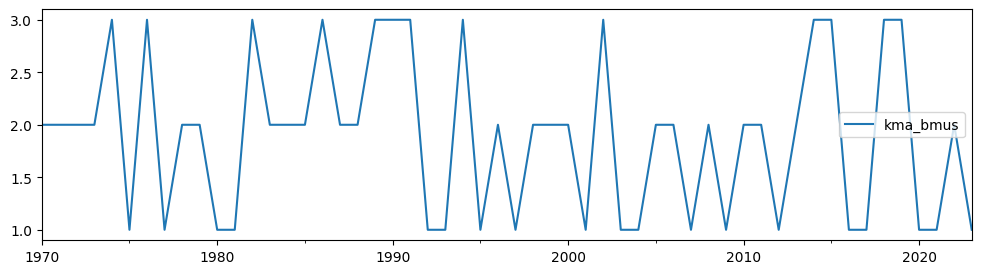

In [4]:
awt.kma_bmus.plot(figsize=(12, 3))

In [5]:
import numpy as np
from bluemath_tk.teslakit.statistical import CopulaSimulation

calculated_PCs = {}
simulated_PCs = {}

for cluster in range(1, awt.num_clusters + 1):
    calculated_PCs[f"{cluster}"] = pca.pcs_df.iloc[
        np.where(awt.kma_bmus == cluster)[0], :
    ].values
    simulated_PCs[f"{cluster}"] = CopulaSimulation(
        U_data=calculated_PCs[f"{cluster}"],
        kernels=["KDE"] * 3,
        num_sim=1000,
    )

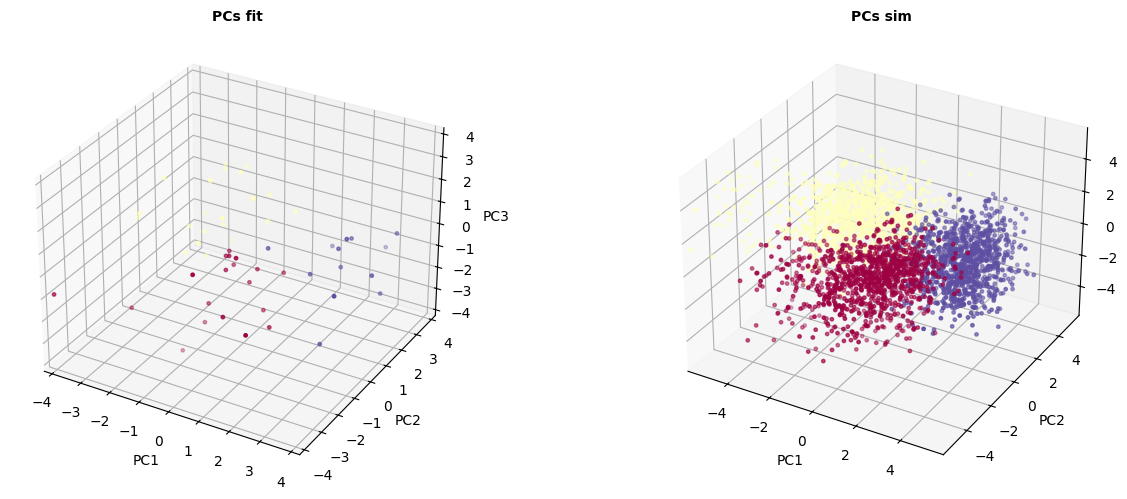

In [6]:
from bluemath_tk.teslakit.plotting.pcs import Plot_PCs_Compare_3D

fig = Plot_PCs_Compare_3D(d_PCs_fit=calculated_PCs, d_PCs_rnd=simulated_PCs)

In [7]:
awt_kma_bmus_df = awt.kma_bmus.copy()
awt_kma_bmus_df.index.name = "time"
awt_kma_bmus_df.columns = ["bmus"]
awt_kma_bmus_ds = awt_kma_bmus_df.to_xarray()
awt_kma_bmus_ds

<xarray.Dataset> Size: 648B
Dimensions:  (time: 54)
Coordinates:
  * time     (time) datetime64[ns] 432B 1970-01-01 1971-01-01 ... 2023-01-01
Data variables:
    bmus     (time) int32 216B 2 2 2 2 3 1 3 1 2 2 1 1 ... 2 3 3 1 1 3 3 1 1 2 1

In [ ]:
from bluemath_tk.teslakit.alr import ALR_WRP

alr_terms = {
    "mk_order": 1,
    "constant": True,
    "long_term": False,
    "seasonality": (False, []),
}

alr_model = ALR_WRP(
    p_base="/workspaces/BlueMath/climate_services/probabilistic/MUSCLE_Aveiro/outputs/awt_alr"
)
alr_model.SetFitData(
    cluster_size=awt.num_clusters,
    xds_bmus_fit=awt_kma_bmus_ds,
    d_terms_settings=alr_terms,
)
alr_model.FitModel(max_iter=1000)


Fitting autoregressive logistic model ...
Optimization done in 0.04 seconds



In [9]:
from datetime import datetime

# --------------------------------------
# Autoregressive Logistic Regression - simulate

# simulation dates (annual array)
y1_sim = 2000
y2_sim = 2100
pca_month_ini = 1
dates_sim = [datetime(y, pca_month_ini, 1) for y in range(y1_sim - 1, y2_sim + 1)]

# launch simulation
ALR_sim = alr_model.Simulate(num_sims=100, time_sim=dates_sim)

# store simulated Annual Weather Types
SST_AWTs_sim = ALR_sim.evbmus_sims.to_dataset()
print(SST_AWTs_sim)

# db.Save_SST_AWT_sim(SST_AWTs_sim)
# SST_AWTs_sim.to_netcdf(op.join(p_dat, 'outputs', 'AWT_SIM_nsims{0}_{1}_{2}.nc'.format(num_sims, y1_sim, y2_sim)))

ALR model fit   : 1970-01-01 --- 2023-01-01
ALR model sim   : 1999-01-01 --- 2100-01-01

Launching 100 simulations...

Sim. Num. 100: 100%|██████████| 101/101 [00:00<00:00, 4223.16it/s]

<xarray.Dataset> Size: 82kB
Dimensions:      (time: 102, n_sim: 100)
Coordinates:
  * time         (time) datetime64[ns] 816B 1999-01-01 2000-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 82kB 2 2 2 2 2 2 2 2 2 ... 1 2 3 2 3 3 1 2


PerpetualYear bmus comparison skipped.
timedelta (days): Hist - 365 days, 0:00:00, Sim - 365)


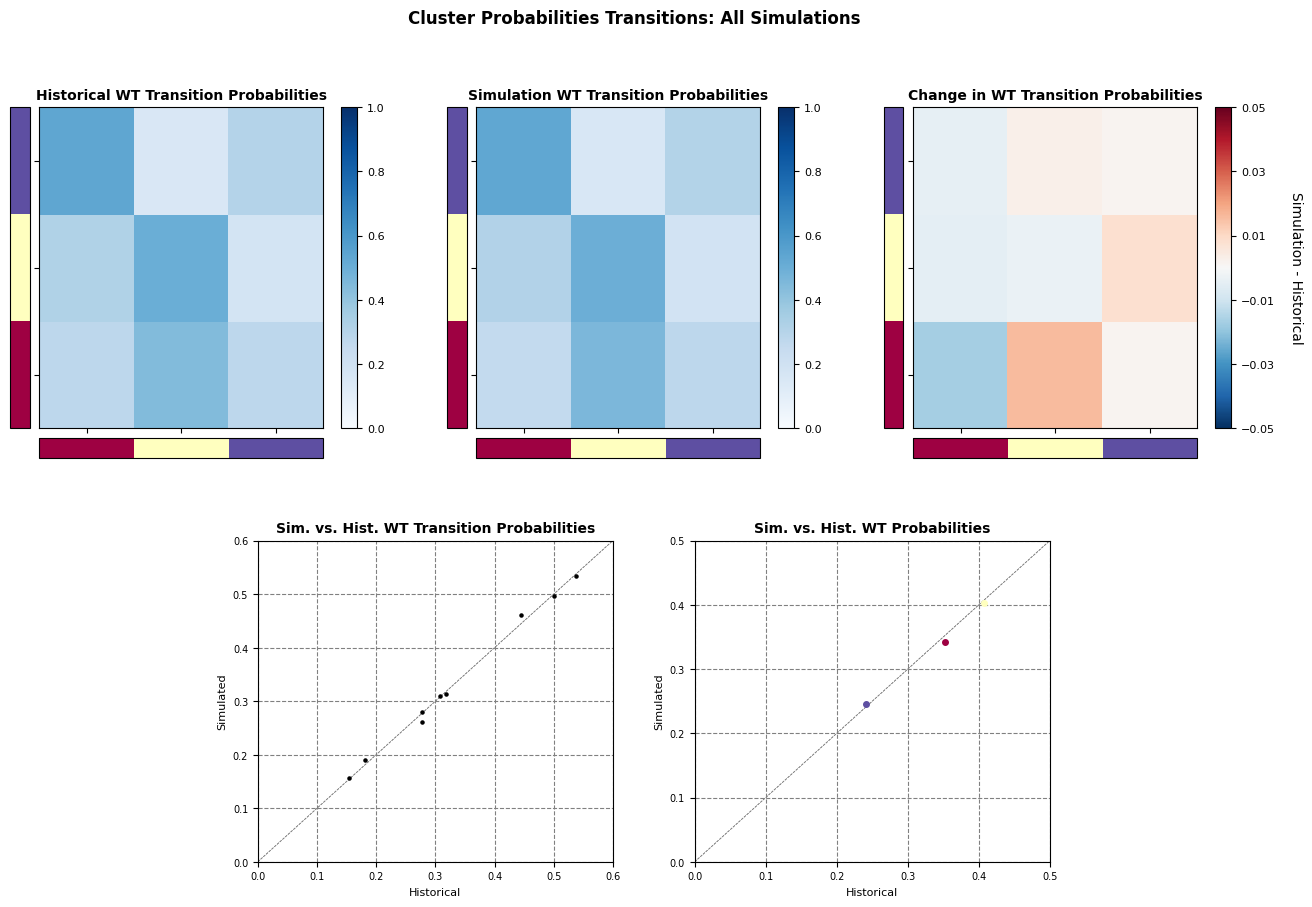

In [10]:
_fig_list = alr_model.Report_Sim()

In [11]:
SST_AWTs_sim

<xarray.Dataset> Size: 82kB
Dimensions:      (time: 102, n_sim: 100)
Coordinates:
  * time         (time) datetime64[ns] 816B 1999-01-01 2000-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 82kB 2 2 2 2 2 2 2 2 2 ... 1 2 3 2 3 3 1 2

In [12]:
import xarray as xr

# Generate PCs of the future!

all_simulated_PCs = np.zeros((100, 102, 3))

for i_simulation in SST_AWTs_sim.n_sim:
    for i_bmus, simulated_bmus in enumerate(
        SST_AWTs_sim.sel(n_sim=i_simulation).evbmus_sims.values
    ):
        all_simulated_PCs[i_simulation, i_bmus, :] = simulated_PCs[f"{simulated_bmus}"][
            np.random.randint(1000)
        ]
# all_simulated_PCs = xr.Dataset(
#     {f"PC{i + 1}": (("n_sim", "time"), all_simulated_PCs[:, :, i]) for i in range(3)},
#     {
#         "n_sim": range(100),
#         "time": SST_AWTs_sim.time.astype("datetime64[ns]"),
#     },
# )
all_simulated_PCs = xr.Dataset(
    {"cov_values": (("n_sim", "time", "n_covariates"), all_simulated_PCs)},
    {
        "n_sim": range(100),
        "time": SST_AWTs_sim.time.astype("datetime64[ns]"),
    },
)
all_simulated_PCs

<xarray.Dataset> Size: 246kB
Dimensions:     (n_sim: 100, time: 102, n_covariates: 3)
Coordinates:
  * time        (time) datetime64[ns] 816B 1999-01-01 2000-01-01 ... 2100-01-01
  * n_sim       (n_sim) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: n_covariates
Data variables:
    cov_values  (n_sim, time, n_covariates) float64 245kB -1.616 ... 3.536

In [13]:
all_simulated_PCs.to_netcdf("outputs/simulated_PCs.nc")